In [2]:
import random 
import matplotlib.pyplot as plt
import numpy as np
import cv2

In [3]:
def translatePoint(p, d):
    x, y = p
    dx, dy = d
    return [x + dx, y + dy]


def homographyTransform(h,p):
    res=h@p
    res=res/res[-1]
    return res[:2].astype('int')

def drawMatches(pt1, img1, pt2, img2, mask, h_mat):
    h1, w1 = img1.shape[:2]
    h2, w2 = img2.shape[:2]
    img = np.zeros(shape=(max(h1, h2), w1 + w2), dtype='uint8')
    img[:h1, :w1] = img1
    img[:h2, w1:] = img2
    img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    x = []
    x.append([0, 0, 1])
    x.append([w1, 0, 1])
    x.append([w1, h1, 1])
    x.append([0, h1, 1])

    tx = [translatePoint(homographyTransform(h_mat, np.array(p)), (w1, 0)) for p in x]
    tx = np.array([tx])
    for i, m in enumerate(mask):
        if m == 1:
            dst = (int(w1 + pt2[i][0]), int(pt2[i][1]))
            src = (int(pt1[i][0]), int(pt1[i][1]))
            #             color=tuple(np.random.randint(0,255,3,dtype='int'))
            color = np.random.randint(0, 255, size=(3), dtype=np.uint8)
            color = (int(color[0]), int(color[1]), int(color[2]))
            cv2.line(img, src, dst, color, thickness=1)
    cv2.polylines(img, tx, isClosed=True, color=color, thickness=2)
    plt.figure(figsize=(20, 18))
    plt.imshow(img)
    plt.show()
    return img


In [4]:
def estimate_3d_homography(correspondences):
    a_list=[]
    for corr in correspondences:
        (x1,y1,z1),(x2,y2,z2)=corr
        xp2=x2/z2
        yp2=y2/z2
        ax=[-x1,-y1,-1,0,0,0,xp2*x1,xp2*y1,xp2]
        ay=[0,0,0,-x1,-y1,-1,yp2*x1,yp2*y1,yp2]
        a_list.append(ax)
        a_list.append(ay)
    mat_a=np.array(a_list)
    u,s,v=np.linalg.svd(mat_a)
    h=np.reshape(v[-1],(3,3))
    return h/h[-1,-1]

def estimate_2d_homography(correspondences):
    new_correspondences=[((x1,y1,1),(x2,y2,1)) for ((x1,y1),(x2,y2)) in correspondences]
    return estimate_3d_homography(new_correspondences)

def apply_2d_homography(point,h):
    x,y=point
    vec=np.array([x,y,1])
    return (h@vec)[:2]

def geometric_distance(correspondence,h):
    (x1,y1),(x2,y2)=correspondence
    X=np.array([x1, y1, 1])
    precited_x2,predicted_y2=(h@X)[:2]
    distance=np.sqrt((x2-precited_x2)**2+(y2-predicted_y2)**2)
    return distance

    

In [5]:
def ransac(correspondences,threshold,n_samples_per_iter=10,n_max_iterations=100):
    best_h=None
    n_max_inliers=0
    for _ in range(n_max_iterations):
        samples=random.sample(correspondences,n_samples_per_iter)
        estimated_h=estimate_2d_homography(samples)
        inlier_counter=0
        for corr in correspondences:
            dist=geometric_distance(corr,estimated_h)
            if dist<threshold:
                inlier_counter+=1
        if inlier_counter>n_max_inliers:
            best_h=estimated_h
    mask=[geometric_distance(corr,np.array(best_h))<threshold for corr in correspondences]
    return best_h,np.array(mask)

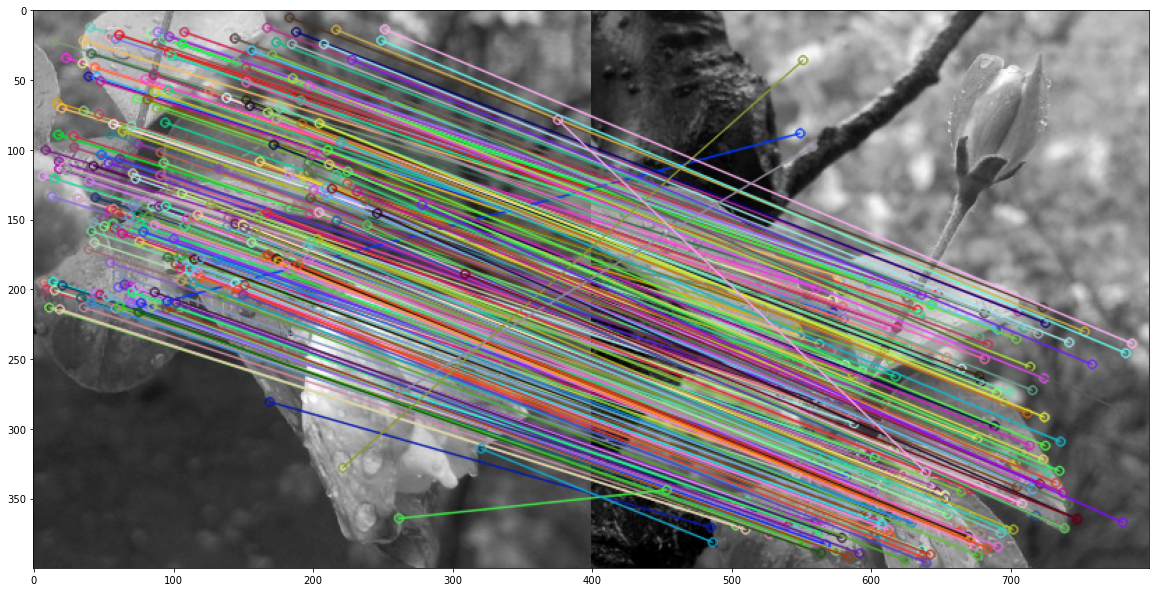

In [6]:
img1=cv2.imread('w1.jpg',0)
img2=cv2.imread('w2.jpg',0)

sift = cv2.SIFT_create()

kp1, des1 = sift.detectAndCompute(img1,None)
kp2, des2 = sift.detectAndCompute(img2,None)

bf = cv2.BFMatcher()
matches = bf.knnMatch(des1,des2, k=2)


good_matches = []
for m,n in matches:
    if m.distance < 0.8*n.distance:
        good_matches.append([m])

img3 = cv2.drawMatchesKnn(img1,kp1,img2,kp2,good_matches,outImg=None,flags=2)
plt.figure(figsize=(20,18))
plt.imshow(img3)

In [15]:
pt1=[kp1[m[0].queryIdx].pt for m in good_matches ]
pt2=[kp2[m[0].trainIdx].pt for m in good_matches ]

corr=list(zip(pt1,pt2))
found_points=[]
for _ in range(100):
    h,mask=ransac(corr,threshold=1,n_samples_per_iter=20,n_max_iterations=10)
    found_points.append(np.sum(mask))
    

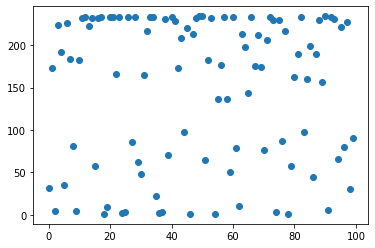

In [19]:
x=np.arange(100)
plt.scatter(x,found_points)

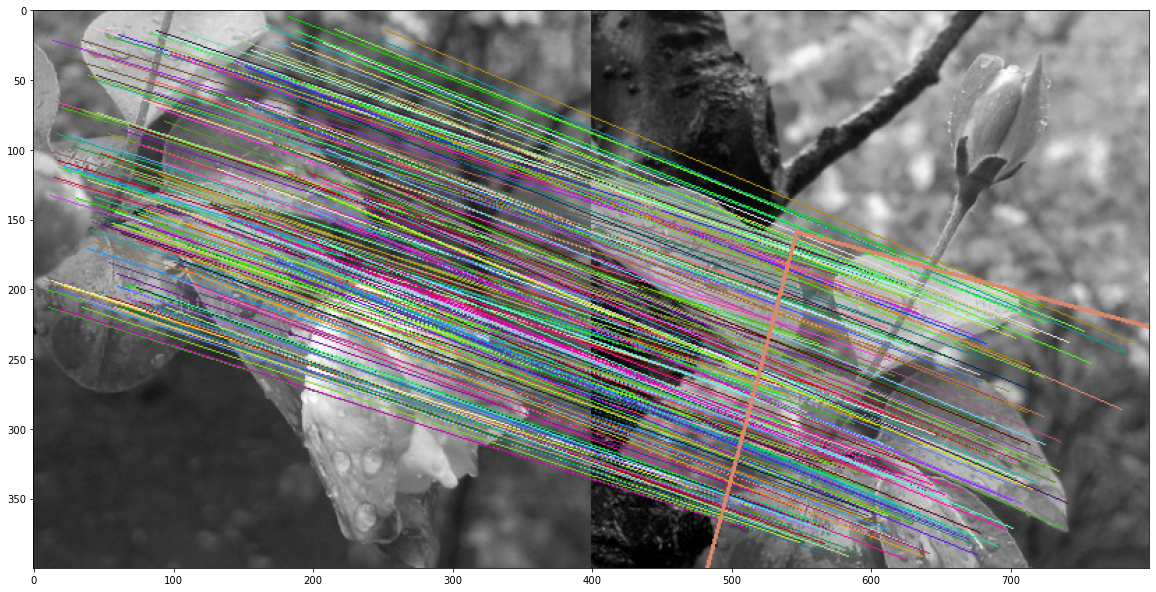

In [26]:
imgg=drawMatches(pt1,img1,pt2,img2,mask,np.array(h))